<!-- ![cov](data/chandler-cover.gif) -->

<h2><center>Could I BE any more sarcastic?</center></h2>
<p align="center">
    <img src="data/chandler-cover.gif">
</p>

## 1. Introduction

### 1.1 Task Description

### 1.2 Ivy Integration

### 1.3 Overview of Results

## 2. Setup

### 2.1 Modules

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

import networkx as nx

from helpers import (get_kaggle_dataset, save_to_pickle, load_from_pickle, show_values_on_bars)

import warnings
warnings.filterwarnings('ignore')

### 2.2 Data Loading

In [2]:
# Connect to Kaggle and download the dataset
train_df, test_df = get_kaggle_dataset()
assert train_df is not None
assert test_df is not None

sarcasm.zip: Skipping, found more recently modified local copy (use --force to force download)


### 2.3 Data Sneak Peak

In [3]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [54]:
# Let's check for duplicated rows
dup_rows_count = len(train_df[train_df.duplicated()])
print(f"There are {dup_rows_count} duplicated rows in the dataset.")

There are 0 duplicated rows in the dataset.


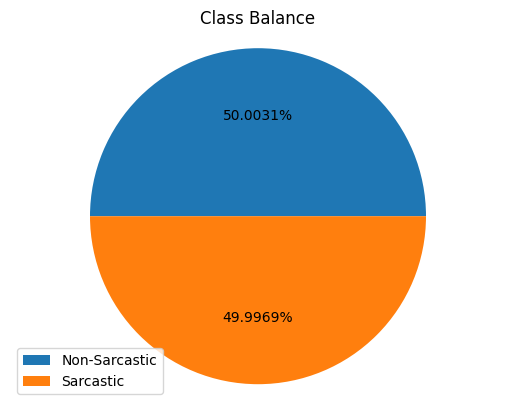

In [53]:
# Let's check for class imbalance
labels = train_df["label"].value_counts()
plt.pie(labels, autopct='%0.4f%%')
plt.axis('equal')

plt.legend(labels.index, labels=["Non-Sarcastic", "Sarcastic"]) 
plt.title("Class Balance")
plt.show()

## 3. Text Mining 📚🔍🌐

### 3.1 Data Preprocessing

TODO:

Tokenization: Splitting text into individual words or tokens.

Lowercasing: Converting all text to lowercase for consistency.

Removing Stop Words: Eliminating common words (e.g., “the,” “and,” “in”) that don’t carry significant meaning.

Stemming and Lemmatization: Reducing words to their root forms (e.g., “running” → “run”).

Removing Punctuation and Special Characters: Cleaning up unwanted symbols.

Handling Misspellings and Typos: Correcting errors.

Removing Redundancy: Ensuring that similar word forms refer to the same meaning.

Encoding Text: Representing text numerically (e.g., using word embeddings).

In [3]:
# remove empty comments
train_df.dropna(subset=['comment'], inplace=True)

# remove duplicate rows
train_df.drop_duplicates(inplace=True)
                         
# convert timestamp into DateTime object
train_df["created_utc"] = pd.to_datetime(train_df["created_utc"])

#### Strategy for Multilevel Text Cleaning

In our approach to building a sarcasm detection model, we adopt a multilevel text cleaning strategy. This involves creating several versions of our dataset's text data, each subjected to a different degree of preprocessing. By training our model on these varied datasets, we aim to discern the impact of specific preprocessing steps on model performance and, consequently, identify the optimal text preprocessing pipeline for sarcasm detection.

1. **Basic Cleaning (`comment_clean`)**: This first level involves applying basic text cleaning operations that are almost universally beneficial for NLP tasks. These include removing URLs, markdown links, subreddit and user mentions, emojis, and excessive whitespace, and converting all text to lowercase. 

2. **Punctuation Removal (`comment_nopunc`)**: Next, we create a version of our text with punctuation removed. Punctuation can sometimes obscure the model's ability to focus on the semantic content of the text. However, in the context of sarcasm detection, punctuation might also play a crucial role in conveying sarcasm.

3. **Stopwords Removal (`comment_nostop`)**: In this version, we further clean the `comment_nopunc` text by removing stopwords. While stopwords are generally considered to carry little semantic weight, their presence or absence might affect the detection of sarcasm, given sarcasm's reliance on context and subtlety.

4. **Lemmatization (`comment_lemmatized`)**: Lastly, we apply lemmatization to the `comment_nostop` text, converting words to their base or dictionary form. This step is aimed at reducing the complexity of the text and standardizing word forms, potentially aiding the model in recognizing patterns. 

In [13]:
def clean_corpus(text, remove_punctuation=False, remove_stopwords=False, lemmatize=False, return_tokenized=True):
    """
    Cleans a text string by removing URLs, markdown links, subreddit and user mentions, emojis, extra spaces,
    and optionally punctuation, stopwords, and applying lemmatization with POS tagging.

    Args:
        text (str): The text string to be cleaned. Typically a single comment.
        remove_punctuation (bool, optional): If True, all punctuation marks will be removed from the text.
        remove_stopwords (bool, optional): If True, stopwords will be removed from the text.
        lemmatize (bool, optional): If True, words will be lemmatized using WordNet lemmatizer with POS tagging.

    Returns:
        str: The cleaned text string after applying the specified preprocessing steps.
    """
    # Compile regex patterns
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    markdown_link_pattern = re.compile(r'\[.*?\]\(.*?\)')
    reddit_user_pattern = re.compile(r'u/\S+')
    reddit_sub_pattern = re.compile(r'r/\S+')
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               "]+", flags=re.UNICODE)

    # Remove URLs
    text = url_pattern.sub('', text)
    # Remove markdown links
    text = markdown_link_pattern.sub('', text)
    # Remove subreddit and user mentions
    text = reddit_user_pattern.sub('', text)
    text = reddit_sub_pattern.sub('', text)
    # Remove emojis
    text = emoji_pattern.sub('', text)

    # Replace newline and tab characters with a space
    text = text.replace('\n', ' ').replace('\t', ' ').replace('\xa0', ' ')
    # Remove extra spaces
    text = ' '.join(text.split())

    # Make lowercase
    text = text.lower()

    # Optionally remove punctuation
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize the text
    tokens = word_tokenize(text)

    # Optionally remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        # TODO: Adding specific stopwords that might be relevant in sarcastic context could be considered here
        tokens = [word for word in tokens if word not in stop_words]

    # Optionally apply lemmatization with POS tagging
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        pos_tokens = pos_tag(tokens)
        tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tokens]

    # Return the list of tokens or join the tokens back into a string
    return tokens if return_tokenized else ' '.join(tokens)

def get_wordnet_pos(treebank_tag):
    """
    Converts a treebank tag to a WordNet part-of-speech tag.

    Args:
        treebank_tag (str): The treebank tag.

    Returns:
        str: The corresponding WordNet part-of-speech tag.
    """
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'  # Default to noun if the tag is not recognized

In [ ]:
# Apply the cleaning function to the comment column
train_df['comment_clean'] = train_df['comment'].apply(clean_corpus) 

In [15]:
train_df['comment_nopunc'] = train_df['comment'].apply(clean_corpus, remove_punctuation=True)   

# Stopword Removal & Lemmatization
train_df['comment_nostop'] = train_df['comment'].apply(clean_corpus, remove_punctuation=True, remove_stopwords=True)
train_df['comment_lemmatized'] = train_df['comment'].apply(clean_corpus, remove_punctuation=True, remove_stopwords=True, lemmatize=True)

In [16]:
save_to_pickle(df=train_df, filename='./data/cleaned_token_df.pkl')

In [17]:
cleaned_df = load_from_pickle(filename='./data/cleaned_token_df.pkl')
cleaned_df[["comment", "comment_clean", "comment_nopunc", "comment_nostop", "comment_lemmatized"]].head()

,comment,comment_clean,comment_nopunc,comment_nostop,comment_lemmatized
0,NC and NH.,"[nc, and, nh, .]","[nc, and, nh]","[nc, nh]","[nc, nh]"
1,You do know west teams play against west teams...,"[you, do, know, west, teams, play, against, we...","[you, do, know, west, teams, play, against, we...","[know, west, teams, play, west, teams, east, t...","[know, west, team, play, west, team, east, tea..."
2,"They were underdogs earlier today, but since G...","[they, were, underdogs, earlier, today, ,, but...","[they, were, underdogs, earlier, today, but, s...","[underdogs, earlier, today, since, gronks, ann...","[underdog, earlier, today, since, gronks, anno..."
3,"This meme isn't funny none of the ""new york ni...","[this, meme, is, n't, funny, none, of, the, ``...","[this, meme, isnt, funny, none, of, the, new, ...","[meme, isnt, funny, none, new, york, nigga, ones]","[meme, isnt, funny, none, new, york, nigga, one]"
4,I could use one of those tools.,"[i, could, use, one, of, those, tools, .]","[i, could, use, one, of, those, tools]","[could, use, one, tools]","[could, use, one, tool]"


### 3.2 EDA

#### Sarcasm Evolution on Reddit over the years

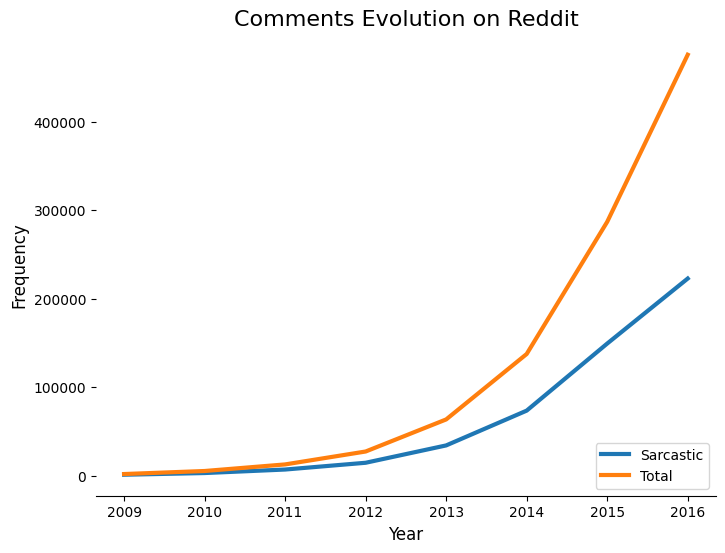

In [9]:
# Yearly evolution

# Create new feature containing only the year the comment was posted
train_df["year"] = train_df["created_utc"].apply(lambda x: x.year)

sarcasm_count_df = train_df[train_df["label"] == 1].groupby("year")["comment"].count().reset_index()
total_count_df = train_df.groupby("year")["comment"].count().reset_index()

# Plot
plt.figure(figsize=(8, 6))
# ax = sns.lineplot(data=date_count_df, x="year", y="comment", lw=8, color=my_colors[3])
ax = sns.lineplot(data=sarcasm_count_df, x="year", y="comment", lw=3, label="Sarcastic")
ax = sns.lineplot(data=total_count_df, x="year", y="comment", lw=3, label="Total")
plt.title("Comments Evolution on Reddit", size=16)
plt.xlabel("Year", size=12)
plt.ylabel("Frequency", size=12)
plt.legend(loc="lower right", fontsize=10)
sns.despine(left=True)

# # Picture
# path='../input/all-elon-musks-tweets/images/images/elon_rocket.png'
# offset_png(x=6.9, y=2000, path=path, ax=ax, zoom=0.27, offset=0)

#### Popularity

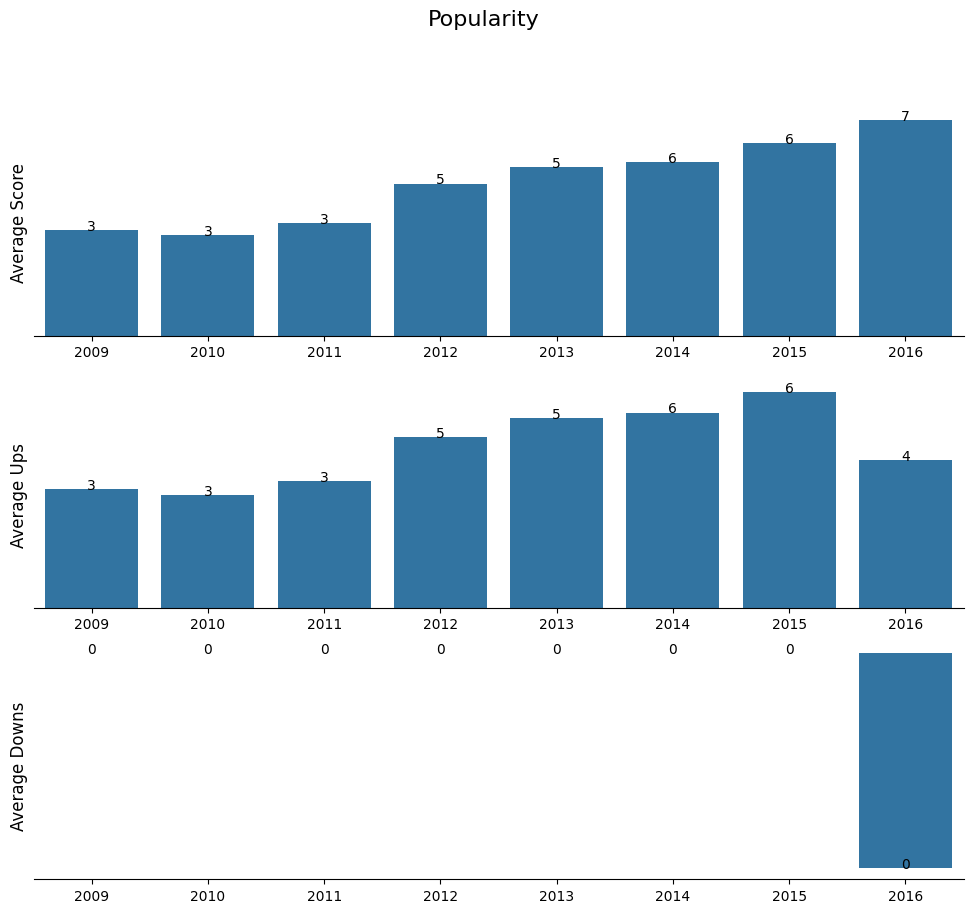

In [10]:
# Get Popularity Information
popularity = ["score", "ups", "downs"]
popularity_df = cleaned_df.groupby("year").agg({popularity[0] : 'sum',
                                                popularity[1] : 'sum',
                                                popularity[2] : 'sum',
                                                'comment' : 'count'}).reset_index()
popularity_df["score_count"] = popularity_df["score"]/popularity_df["comment"]
popularity_df["ups_count"] = popularity_df["ups"]/popularity_df["comment"]
popularity_df["downs_count"] = popularity_df["downs"]/popularity_df["comment"]

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 10))
axs = [ax1, ax2, ax3]
plt.suptitle("Popularity", size=16)
# sns.barplot(data=popularity_df, x="year", y="likes_count", lw=5, color=my_colors[0], ax=ax1)
# sns.barplot(data=popularity_df, x="year", y="retweets_count", lw=5, color=my_colors[1], ax=ax2)
# sns.barplot(data=popularity_df, x="year", y="replies_count", lw=5, color=my_colors[2], ax=ax3)
sns.barplot(data=popularity_df, x="year", y="score_count", lw=2,  ax=ax1)
sns.barplot(data=popularity_df, x="year", y="ups_count", lw=2,  ax=ax2)
sns.barplot(data=popularity_df, x="year", y="downs_count", lw=2, ax=ax3)
names = ["Average Score", "Average Ups", "Average Downs"]
for ax, n in zip(axs, names):
    ax.set_xlabel("", size=12)
    ax.set_ylabel(n, size=12)
    ax.get_yaxis().set_ticks([])
    show_values_on_bars(axs=ax, h_v="v", space=0.4)
sns.despine(left=True)

#### Let's take a look at subreddits

In [11]:
from termcolor import colored

topn = 3

# Get the top 5 subreddits based on the total score of their comments
top_subreddits = cleaned_df.groupby('subreddit')['score'].sum().nlargest(5).index

for subreddit in top_subreddits:
    # Filter the DataFrame for the current subreddit & Get the top 3 comments
    top_comments = cleaned_df[cleaned_df['subreddit'] == subreddit].nlargest(topn, 'score')
    
    # Print the subreddit name in blue and bold
    print(colored(f"\nSubreddit: {subreddit}", 'blue', attrs=['bold']))
    
    # Print the top comments 
    for i, row in enumerate(top_comments.itertuples(index=False), start=1):
        author = colored(f"@{row.author}", 'green')
        score = colored(f"Score: {row.score}", 'red')
        comment = row.comment
        print(f"{i}. {author}: {comment} ({score})")


Subreddit: AskReddit
1. @superswellcewlguy: In the Half Life series, the reason Gordon Freeman doesn't talk is because he keeps all his weapons in his mouth. (Score: 5163)
2. @ThatsNotCoolBro14: Maybe you should stop being a man? (Score: 4981)
3. @Siqqi: Getting pushed back by the impact of a bullet. (Score: 4909)

Subreddit: politics
1. @MonsieurIneos: TIL That 12,000+ dollar jackets exist, and people actually buy them. (Score: 2987)
2. @t7george: Jeb Bush winning over Millennials one gaff at a time. (Score: 1684)
3. @rtft: Well, he says he's done nothing wrong, so it shouldn't be an issue , right (Score: 1553)

Subreddit: worldnews
1. @ThePandagator: That's exactly what a country who made up a hoax about climate change would say! (Score: 9070)
2. @Zoso03: but it still snows (Score: 7563)
3. @_Nasna: Fuckin love this season finale. (Score: 2564)

Subreddit: news
1. @LaceratedCantaloupe: A respectable candidate. (Score: 4057)
2. @notreallyhereforthis: I love how he was banned from wor

#### TO DO

#### Most Frequent Words

In [12]:
from wordcloud import WordCloud
font_path = "./data/acetone_font.otf"


def create_word_cloud(text, title):
    
    wordcloud = WordCloud(width=2000, height=1000, colormap="twilight", font_path=font_path,
                          max_words=1500, max_font_size=350, random_state=42, ).generate(text)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    # plt.tight_layout(pad=0)
    plt.title(title, fontsize=20)
    plt.show()

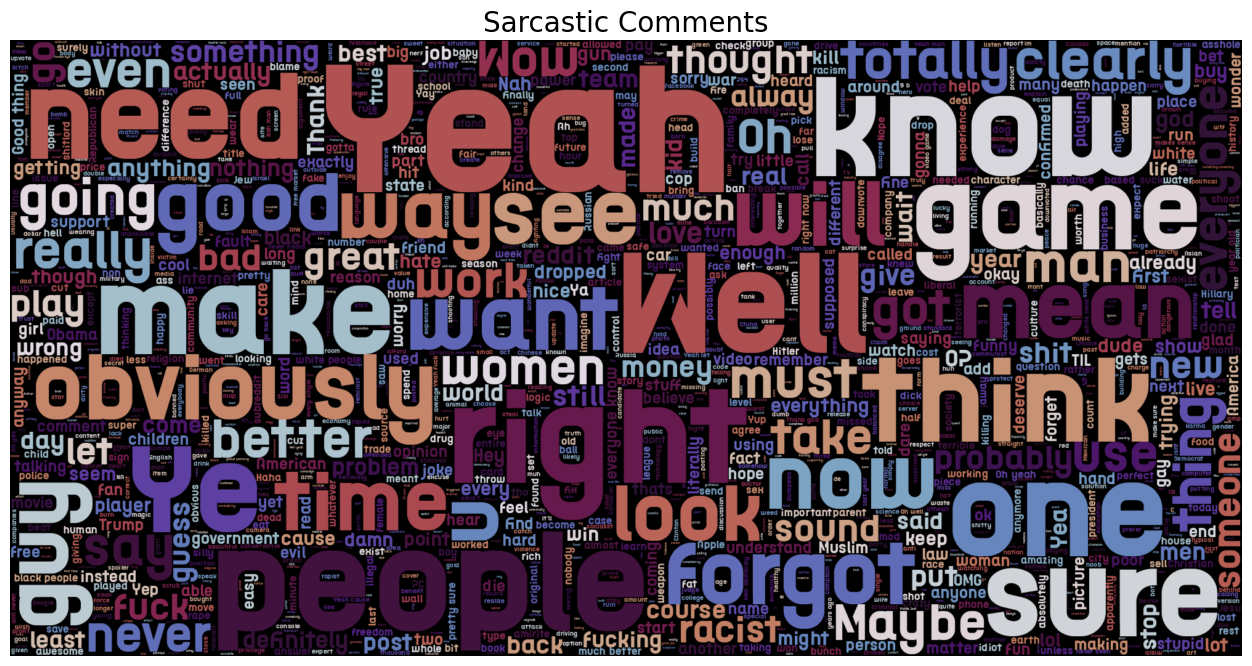

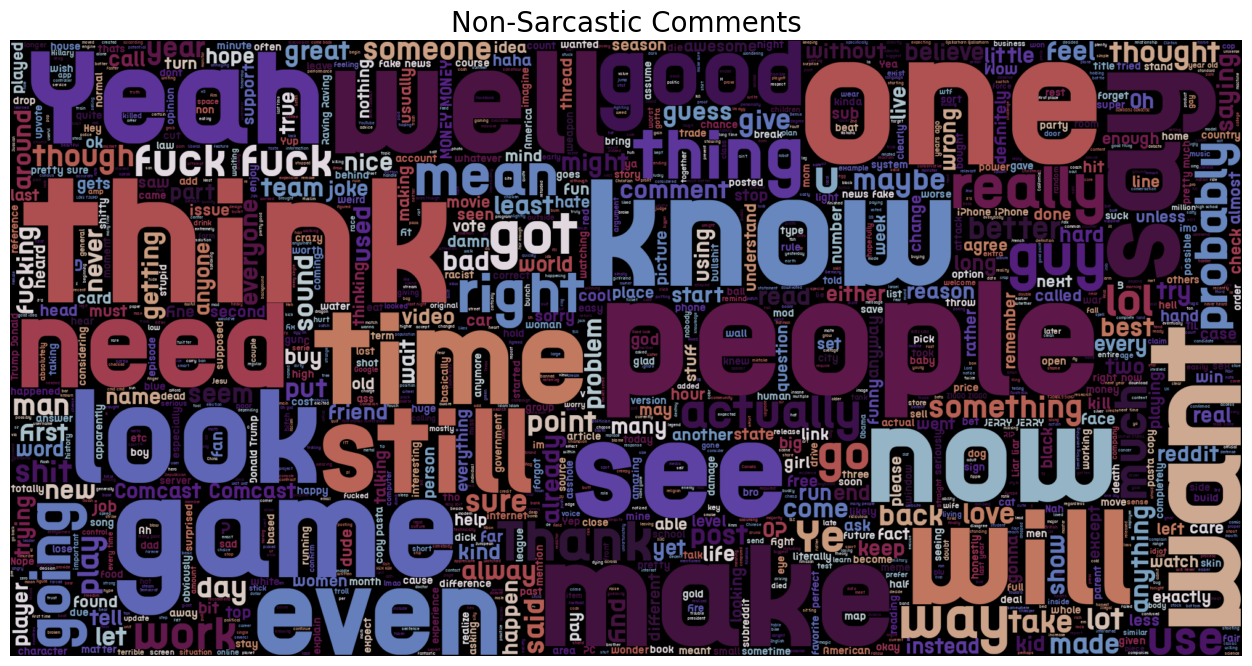

In [13]:
sarcastic_comments = " ".join(cleaned_df[cleaned_df["label"] == 1]["comment"])
non_sarcastic_comments = " ".join(cleaned_df[cleaned_df["label"] == 0]["comment"])

create_word_cloud(sarcastic_comments, "Sarcastic Comments")
create_word_cloud(non_sarcastic_comments, "Non-Sarcastic Comments")

#### Unigrams | Bigrams | Trigrams

In [19]:
import nltk
from nltk import ngrams
from collections import Counter

def get_top_subreddits(df, top_n=5):
    """
    Get the top N subreddits based on the number of comments.

    Args:
        df (pandas.DataFrame): The dataset containing the comments and subreddit information.
        top_n (int): The number of top subreddits to retrieve.

    Returns:
        list: A list of the top N subreddits.
    """
    subreddit_counts = df["subreddit"].value_counts()
    top_subreddits = subreddit_counts.head(top_n).index.tolist()
    return top_subreddits

def unigram_analysis(df, subreddits, col="comment", top_n=5):
    """
    Perform unigram analysis on the dataset, considering the top N words in sarcastic comments for each subreddit.

    Args:
        df (pandas.DataFrame): The dataset containing the comments and subreddit information.
        subreddits (list): The list of subreddits to consider for analysis.
        col (str): The name of the column to retrieve the comments from.
        top_n (int): The number of top words to retrieve for each subreddit.

    Returns:
        dict: A dictionary with subreddits as keys and lists of top N words as values.
    """
    unigram_results = {}
    
    for subreddit in subreddits:
        subreddit_comments = df[(df["subreddit"] == subreddit) & (df["label"] == 1)][col]
        words = [word.lower() for comment in subreddit_comments for word in nltk.word_tokenize(comment)]
        word_freq = Counter(words)
        top_words = [word for word, freq in word_freq.most_common(top_n)]
        unigram_results[subreddit] = top_words
    return unigram_results

def bigram_analysis(df, col="comment", top_n=10):
    """
    Perform bigram analysis on the sarcastic comments in the dataset.

    Args:
        df (pandas.DataFrame): The dataset containing the comments and sarcasm labels.
        col (str): The name of the column to retrieve the comments from.
        top_n (int): The number of top bigrams to retrieve.

    Returns:
        list: A list of the top N bigrams in the sarcastic comments.
    """
    sarcastic_comments = df[df["label"] == 1][col]
    bigrams = [bigram for comment in sarcastic_comments for bigram in ngrams(nltk.word_tokenize(comment), 2)]
    bigram_freq = Counter(bigrams)
    top_bigrams = [" ".join(bigram) for bigram, freq in bigram_freq.most_common(top_n)]
    return top_bigrams

def trigram_analysis(df, col="comment", top_n=10):
    """
    Perform trigram analysis on the sarcastic comments in the dataset.

    Args:
        df (pandas.DataFrame): The dataset containing the comments and sarcasm labels.
        top_n (int): The number of top trigrams to retrieve.

    Returns:
        list: A list of the top N trigrams in the sarcastic comments.
    """
    sarcastic_comments = df[df["label"] == 1][col]
    trigrams = [trigram for comment in sarcastic_comments for trigram in ngrams(nltk.word_tokenize(comment), 3)]
    trigram_freq = Counter(trigrams)
    top_trigrams = [" ".join(trigram) for trigram, freq in trigram_freq.most_common(top_n)]
    return top_trigrams

def bigram_network_analysis(df, col="comment", top_n=30):
    """
    Perform bigram network analysis on the sarcastic comments in the dataset.

    Args:
        df (pandas.DataFrame): The dataset containing the comments and sarcasm labels.
        top_n (int): The number of top bigrams to include in the network.

    Returns:
        networkx.Graph: The bigram network graph.
    """
    sarcastic_comments = df[df["label"] == 1][col]
    bigrams = [bigram for comment in sarcastic_comments for bigram in ngrams(nltk.word_tokenize(comment), 2)]
    bigram_freq = Counter(bigrams)
    
    top_bigrams = bigram_freq.most_common(top_n)
    
    G = nx.Graph()
    for bigram, freq in top_bigrams:
        word1, word2 = bigram
        G.add_edge(word1, word2, weight=freq)
    
    return G

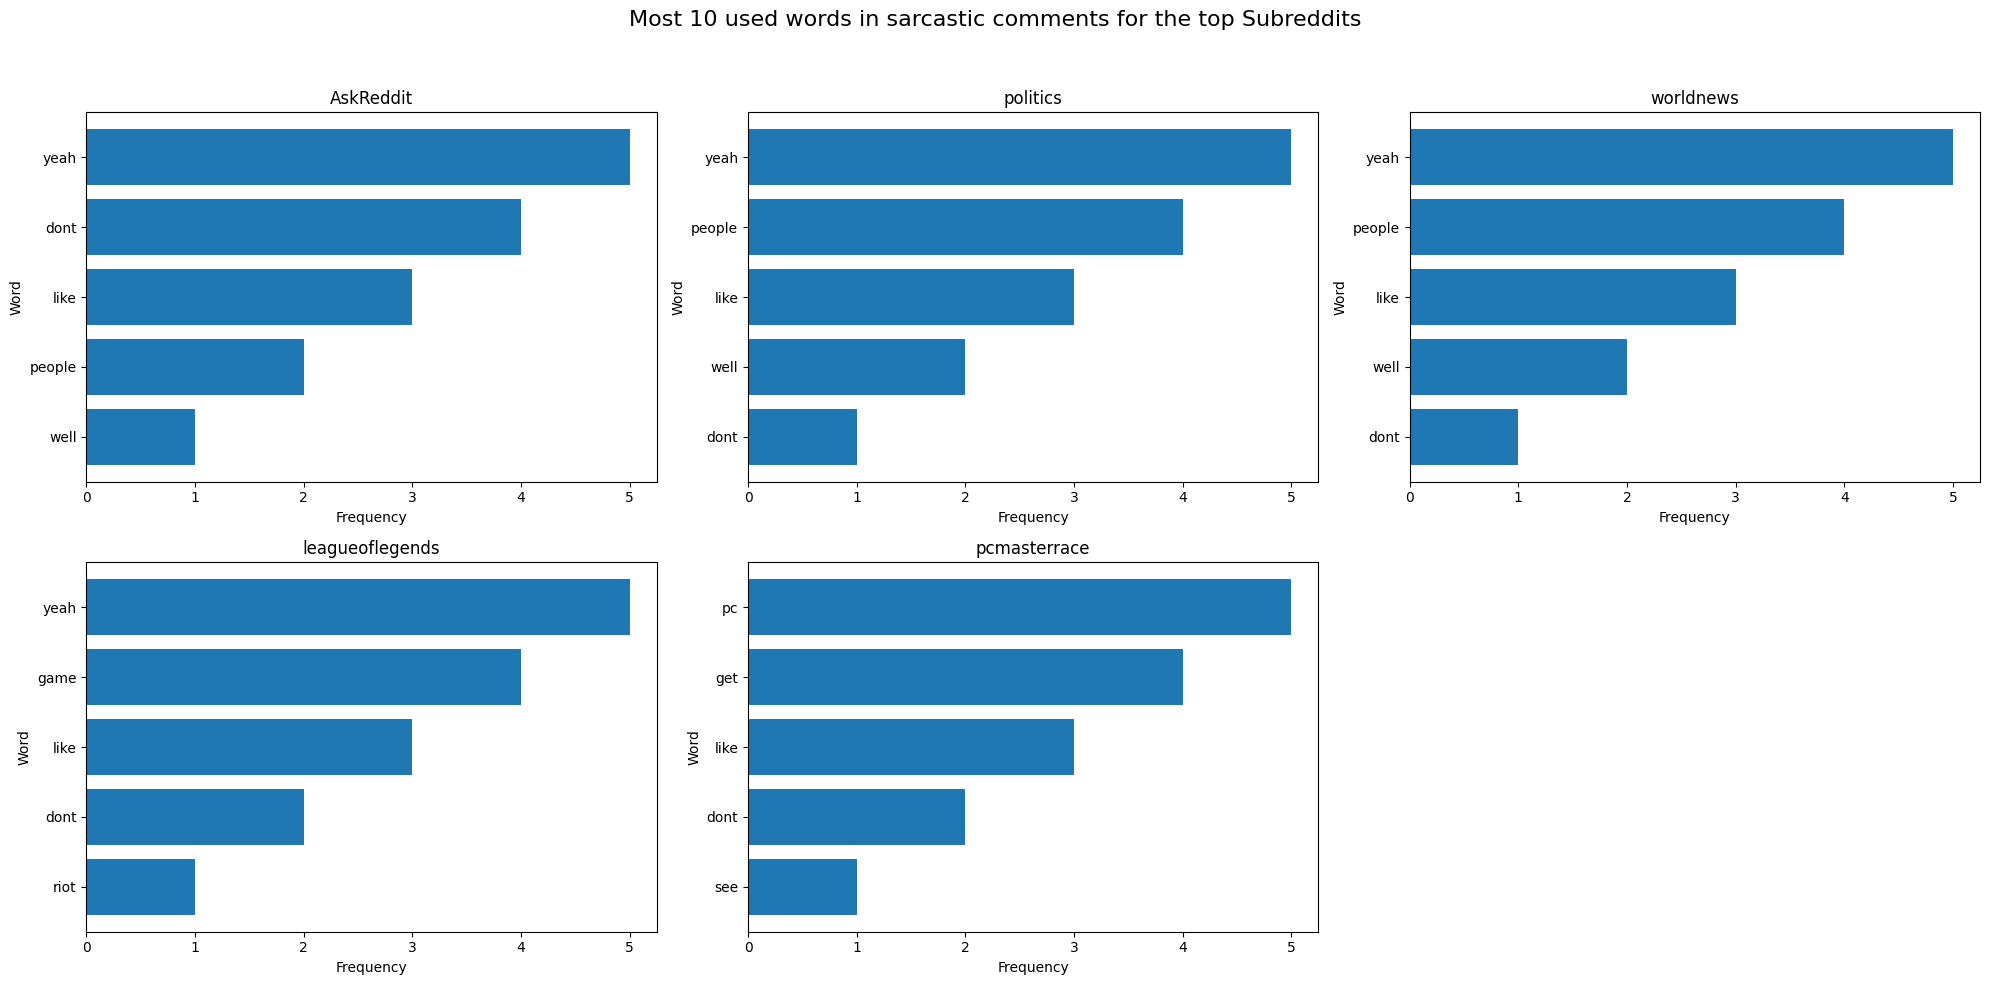

In [23]:
top_subreddits = get_top_subreddits(cleaned_df, top_n=5)
# print(f"Top {len(top_subreddits)} subreddits: {', '.join(top_subreddits)}\n")

unigram_results = unigram_analysis(cleaned_df, top_subreddits, col="comment_nostop")

# Visualize unigram analysis
num_rows = (len(top_subreddits) + 2) // 3
num_cols = min(3, len(top_subreddits))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows))
fig.suptitle("Most 10 used words in sarcastic comments for the top Subreddits", fontsize=16)

for i, subreddit in enumerate(top_subreddits):
    row = i // num_cols
    col = i % num_cols
    
    top_words = unigram_results[subreddit]
    axes[row, col].barh(top_words, range(len(top_words), 0, -1))
    axes[row, col].set_title(subreddit)
    axes[row, col].set_xlabel("Frequency")
    axes[row, col].set_ylabel("Word")
    axes[row, col].invert_yaxis()
    
# Remove empty axes
for i in range(len(top_subreddits), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    plt.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

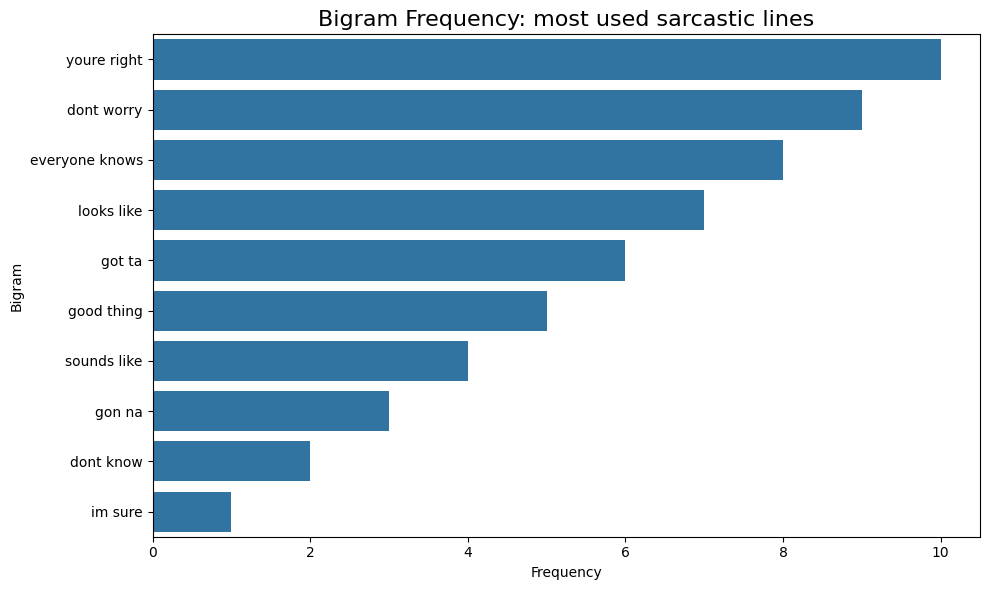

In [22]:
top_bigrams = bigram_analysis(cleaned_df, col="comment_nostop")

# Visualize bigram analysis
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(1, len(top_bigrams)+1)), y=top_bigrams, orient="h")
plt.title("Bigram Frequency: most used sarcastic lines", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
# Visualize bigram network
bigram_network = bigram_network_analysis(cleaned_df, col="comment_nostop")

# plt.figure(figsize=(12, 8))
# pos = nx.spring_layout(bigram_network, k=0.8)
# nx.draw_networkx_nodes(bigram_network, pos, node_size=300, node_color='lightblue')
# nx.draw_networkx_edges(bigram_network, pos, edge_color='gray', width=1.0)
# nx.draw_networkx_labels(bigram_network, pos, font_size=6, font_family='sans-serif')
# labels = nx.get_edge_attributes(bigram_network, 'weight')
# # nx.draw_networkx_edge_labels(bigram_network, pos, edge_labels=labels, font_size=6)
# plt.title("Bigram Network (Top 30)", fontsize=16)
# plt.axis('off')
# plt.tight_layout()
# plt.show()

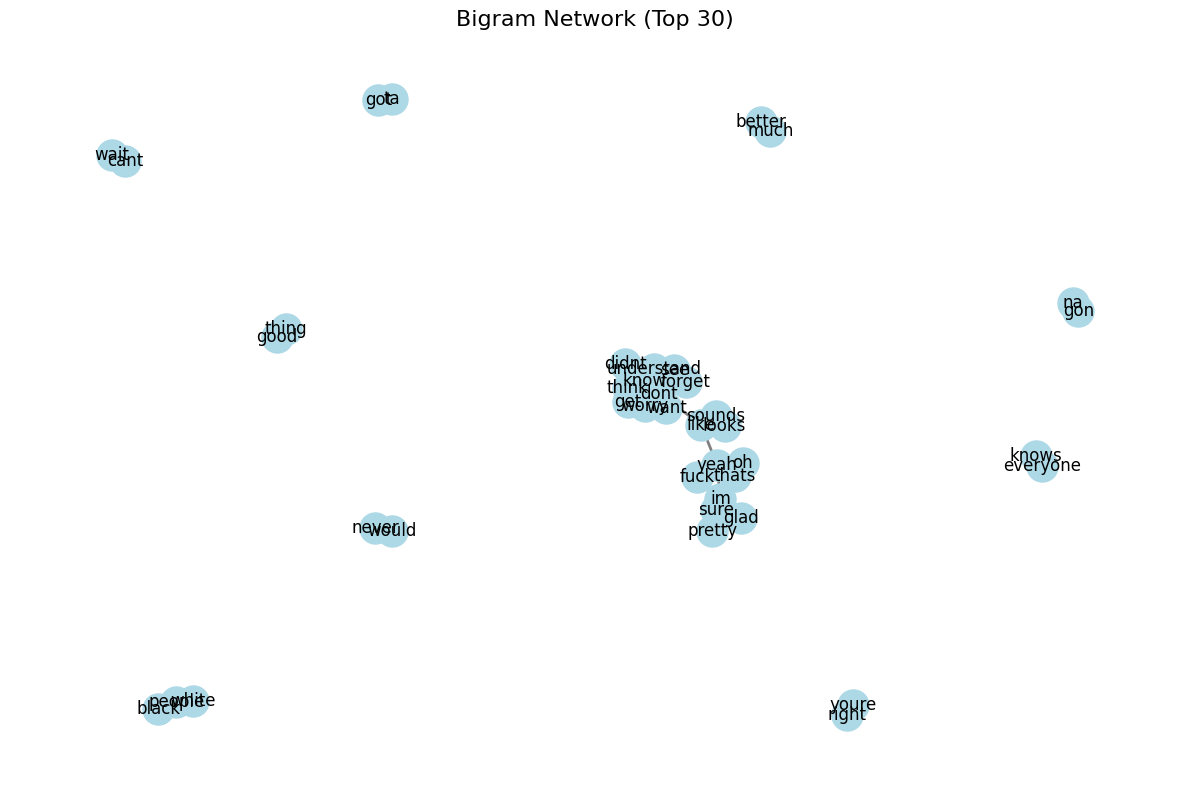

In [26]:
# Visualize bigram network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(bigram_network, k=0.6)  # Adjust the k parameter for spacing

# Adjust the node size and font size
nx.draw_networkx_nodes(bigram_network, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_labels(bigram_network, pos, font_size=12, font_family='sans-serif')

# Adjust the edge width based on the weight
edge_widths = [d['weight'] / 10 for (u, v, d) in bigram_network.edges(data=True)]
edge_widths = 2
nx.draw_networkx_edges(bigram_network, pos, width=edge_widths, edge_color='gray')

# Remove the edge labels
# nx.draw_networkx_edge_labels(bigram_network, pos, edge_labels=labels, font_size=6)

plt.title("Bigram Network (Top 30)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

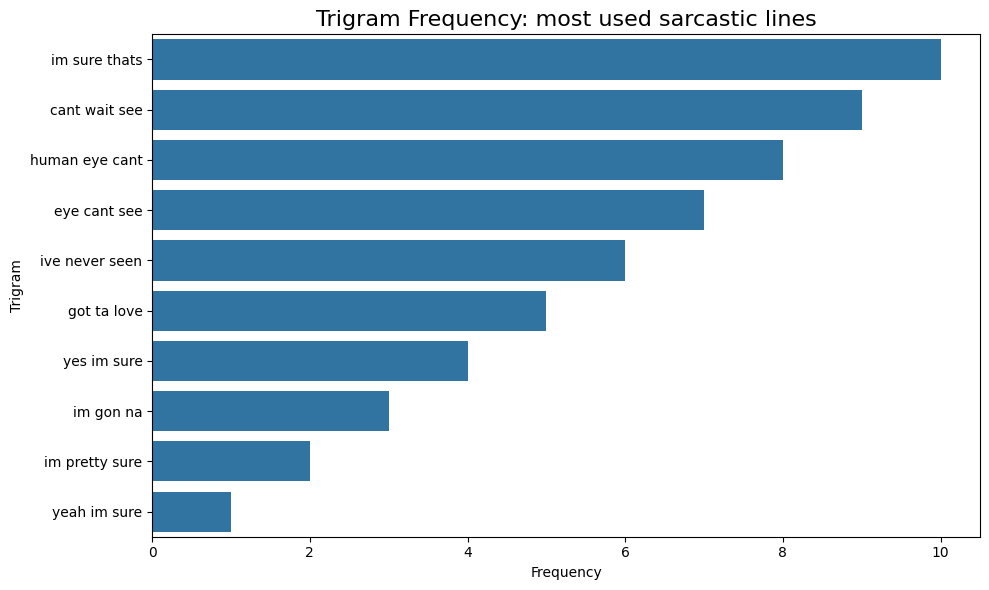

In [27]:
top_trigrams = trigram_analysis(cleaned_df, col="comment_nostop")

# Visualize trigram analysis
plt.figure(figsize=(10, 6))
sns.barplot(x=list(range(1, len(top_trigrams)+1)), y=top_trigrams, orient="h")
plt.title("Trigram Frequency: most used sarcastic lines", fontsize=16)
plt.xlabel("Frequency")
plt.ylabel("Trigram")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 3. Modelling

In [ ]:
## LSTM Model 1
from models.lstm_model import *

# Define the hyperparameter grid for tuning
param_grid = {
    'embedding_dim': [30, 40, 50],
    'lstm_units': [80, 100, 120],
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Experiment with different levels of text cleaning
for text_column in ['comment_clean', 'comment_nopunc', 'comment_nostop', 'comment_lemmatized']:
    print(f"\nResults for {text_column}:")
    
    # Initialize the SarcasmDetectionModel
    model = SarcasmDetectionModel(cleaned_df, text_column, 'label')
    
    # Preprocess the data
    model.preprocess_data()
    
    # Split the data into train and test sets
    model.split_data()
    
    # Perform hyperparameter tuning
    model.tune_hyperparameters(param_grid, debug=True)
    
    # Train the model with the best hyperparameters
    model.train_model()
    
    # Evaluate the model
    model.evaluate_model()

In [ ]:
# LSTM Model 2
from models.lstm_model2 import *

def preprocess_text_for_lstm(corpus, vocab_size=5000, max_length=20):
    """
    Preprocess the text data for LSTM training.
    
    Parameters:
    corpus (pd.Series): Corpus of text data.
    vocab_size (int): Size of the vocabulary for one-hot encoding.
    max_length (int): Maximum length of the sequences.
    
    Returns:
    np.array: Preprocessed and padded sequences ready for LSTM training.
    """
    # One-hot encode the corpus
    onehot_encoded = [one_hot(text, vocab_size) for text in corpus]
    
    # Pad the sequences
    padded_sequences = pad_sequences(onehot_encoded, padding='pre', maxlen=max_length)
    
    return np.array(padded_sequences)

# Assuming cleaned_df is the DataFrame with the different levels of cleaned text
clean_levels = ['comment_clean', 'comment_nopunc', 'comment_nostop', 'comment_lemmatized']
results = {}

# Training and evaluation loop with print statements for each level of cleaning
best_accuracy = 0
best_level = ''
debug = True  # Set this to True if you want detailed print statements

for level in clean_levels:
    print(f'\nProcessing level: {level}')
    corpus = cleaned_df[level].astype(str)
    X = preprocess_text_for_lstm(corpus)
    y = np.array(cleaned_df['label'])
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
    # Initialize and train the model
    sarcasm_detector = SarcasmDetectorLSTM()
    history = sarcasm_detector.fit(X_train, y_train, X_test, y_test, debug=debug)
    
    # Evaluate the model
    loss, accuracy = sarcasm_detector.evaluate(X_test, y_test)
    
    # Check if this is the best model so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_level = level
        print("New best model found!")
    
    # Store the results
    results[level] = {'loss': loss, 'accuracy': accuracy}

# After all models are trained and evaluated
print(f"\nBest performing model was on the '{best_level}' with an accuracy of {best_accuracy:.4f}.")

In [1]:
import tensorflow

2024-04-01 23:03:19.957398: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 23:03:20.211203: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-01 23:03:21.046287: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 23:03:34.930231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/mnt/c/Users/denad/OneDrive/Desktop/projects/unifyai-demos/unify_env_tf/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known

In [2]:
from tensorflow.keras.layers import Embedding

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from scikeras.wrappers import KerasClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class SarcasmDetectionModel:
    def __init__(self, data, text_column, label_column, vocab_size=5000, max_sequence_length=20):
        """
        Initialize the SarcasmDetectionModel.

        Args:
            data (pandas.DataFrame): The input dataset containing text and labels.
            text_column (str): The name of the column containing the text data.
            label_column (str): The name of the column containing the labels.
            vocab_size (int): The size of the vocabulary for one-hot encoding.
            max_sequence_length (int): The maximum length of the input sequences.
        """
        self.data = data
        self.text_column = text_column
        self.label_column = label_column
        self.vocab_size = vocab_size
        self.max_sequence_length = max_sequence_length

    def preprocess_data(self):
        """
        Preprocess the text data by converting it to one-hot encoded sequences.
        """
        # Convert text to one-hot encoded sequences
        corpus = [self.data[self.text_column][i] for i in range(len(self.data))]
        onehot_encoded = [one_hot(words, self.vocab_size) for words in corpus]

        # Pad sequences to a fixed length
        self.X = pad_sequences(onehot_encoded, padding='pre', maxlen=self.max_sequence_length)
        self.y = np.array(self.data[self.label_column])

    def split_data(self, test_size=0.2, random_state=42):
        """
        Split the preprocessed data into training and testing sets.

        Args:
            test_size (float): The proportion of the dataset to include in the test split.
            random_state (int): The seed used by the random number generator.
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size, random_state=random_state
        )

    def build_model(self, embedding_dim=40, lstm_units=100, dropout_rate=0.3):
        """
        Build the Bidirectional LSTM model architecture.

        Args:
            embedding_dim (int): The dimensionality of the embedding layer.
            lstm_units (int): The number of units in the LSTM layer.
            dropout_rate (float): The dropout rate for regularization.

        Returns:
            The compiled Bidirectional LSTM model.
        """
        model = Sequential()
        model.add(Embedding(self.vocab_size, embedding_dim, input_length=self.max_sequence_length))
        model.add(Dropout(dropout_rate))
        model.add(Bidirectional(LSTM(lstm_units)))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        print("Model structure:")
        model.summary()

        return model

    def tune_hyperparameters(self, params, debug=False):
        """
        Perform hyperparameter tuning using GridSearchCV.

        Args:
            params (dict): The hyperparameter grid to search over.
            debug (bool): Whether to print debugging information.
        """
        def build_model_wrapper(embedding_dim, lstm_units, dropout_rate):
            return self.build_model(embedding_dim, lstm_units, dropout_rate)

        model = KerasClassifier(build_fn=build_model_wrapper, verbose=0)
        grid = GridSearchCV(estimator=model, param_grid=params, cv=3, verbose=2)
        grid_result = grid.fit(self.X_train, self.y_train)

        if debug:
            print("Hyperparameter sets:")
            means = grid_result.cv_results_['mean_test_score']
            stds = grid_result.cv_results_['std_test_score']
            params = grid_result.cv_results_['params']
            for mean, std, param in zip(means, stds, params):
                print(f"Hyperparameters: {param}")
                print(f"Mean test score: {mean:.4f} (std: {std:.4f})")
                print()

        print("Best hyperparameters: %s" % (grid_result.best_params_))
        self.best_params_ = grid_result.best_params_

    def train_model(self, epochs=10, batch_size=64):
        """
        Train the Bidirectional LSTM model using the best hyperparameters.

        Args:
            epochs (int): The number of epochs to train the model.
            batch_size (int): The batch size used during training.
        """
        self.model = self.build_model(**self.best_params_)
        print("Model training started...")
        history = self.model.fit(self.X_train, self.y_train, validation_data=(self.X_test, self.y_test),
                                 epochs=epochs, batch_size=batch_size)
        print("Model training finished.")

        print("Training history:")
        for epoch, (loss, accuracy) in enumerate(zip(history.history['loss'], history.history['accuracy']), start=1):
            print(f"Epoch {epoch}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")

    def evaluate_model(self):
        """
        Evaluate the trained model on the test set and print the evaluation metrics.
        """
        y_pred = (self.model.predict(self.X_test) > 0.5).astype("int32")
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-score: {f1:.4f}")

ModuleNotFoundError: No module named 'scikeras'